# Random Forests Method for the January Tabular Data Challenge
## Step 1. Building the Model

In [1]:
import pandas as pd
import numpy as np
import holidays
from xgboost import XGBRegressor, plot_importance
from sklearn.preprocessing import OneHotEncoder
from IPython.display import display

random_state = 3165
stores_data = pd.read_csv("data/train.csv", index_col='row_id')
stores_data['date'] = pd.to_datetime(stores_data['date'], format='%Y-%m-%d')
display(stores_data.head())
display(stores_data.tail())

,date,country,store,product,num_sold
row_id,,,,,
0,2015-01-01,Finland,KaggleMart,Kaggle Mug,329
1,2015-01-01,Finland,KaggleMart,Kaggle Hat,520
2,2015-01-01,Finland,KaggleMart,Kaggle Sticker,146
3,2015-01-01,Finland,KaggleRama,Kaggle Mug,572
4,2015-01-01,Finland,KaggleRama,Kaggle Hat,911


,date,country,store,product,num_sold
row_id,,,,,
26293,2018-12-31,Sweden,KaggleMart,Kaggle Hat,823
26294,2018-12-31,Sweden,KaggleMart,Kaggle Sticker,250
26295,2018-12-31,Sweden,KaggleRama,Kaggle Mug,1004
26296,2018-12-31,Sweden,KaggleRama,Kaggle Hat,1441
26297,2018-12-31,Sweden,KaggleRama,Kaggle Sticker,388


In [2]:
def one_hot_encode(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)
    oh_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
    oh_df = pd.DataFrame(oh_encoder.fit_transform(df[object_cols]))
    oh_df.index = df.index
    num_cols = df.drop(object_cols, axis=1)
    df = pd.concat([num_cols, oh_df], axis=1)
    df.columns = df.columns.astype(str)
    oh_df.columns = oh_df.columns.astype(str)
    return df, list(oh_df.columns)

In [3]:
def create_time_features(df: pd.DataFrame, date_key='date'):
    """
    Author: Rob Mulla, Robin Onsay
    link: https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost
    :param df:
    :param date_key:
    :return:
    """
    df['dayofweek'] = df[date_key].dt.dayofweek
    df['quarter'] = df[date_key].dt.quarter
    df['month'] = df[date_key].dt.month
    df['year'] = df[date_key].dt.year
    df['day_of_year'] = df[date_key].dt.dayofyear
    df['day_of_month'] = df[date_key].dt.day
    df['week_of_year'] = np.int64(df[date_key].dt.isocalendar().week)
    is_holiday = lambda x: (x[date_key] in holidays.CountryHoliday(x['country']))
    df['is_holiday'] = df.apply(is_holiday, axis=1)
    df['is_month_start'] = df[date_key].dt.is_month_start
    df['is_month_end'] = df[date_key].dt.is_month_end
    df['is_quarter_start'] = df[date_key].dt.is_quarter_start
    df['is_quarter_end'] = df[date_key].dt.is_quarter_end
    df['is_year_start'] = df[date_key].dt.is_year_start
    df['is_year_end'] = df[date_key].dt.is_year_end
    df['is_leap_year'] = df[date_key].dt.is_leap_year
    return ['dayofweek', 'quarter',
            'month', 'year',
            'day_of_year', 'day_of_month',
            'week_of_year', 'is_holiday',
            'is_month_start', 'is_month_end',
            'is_quarter_start', 'is_quarter_end',
            'is_year_start', 'is_year_end',
            'is_leap_year']

In [4]:
time_features = create_time_features(stores_data)
stores_data, oh_cols = one_hot_encode(stores_data)

In [5]:
split_date = '2017-12-31'
stores_data_train = stores_data.loc[stores_data['date'] <= split_date].copy()
stores_data_val = stores_data.loc[stores_data['date'] > split_date].copy()

In [6]:
features = oh_cols + time_features
X_train = stores_data_train[features]
y_train = stores_data_train.num_sold
X_val = stores_data_val[features]
y_val = stores_data_val.num_sold
display(X_train.head())
display(X_val.head())

,0,1,2,3,4,5,6,7,dayofweek,quarter,...,day_of_month,week_of_year,is_holiday,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
row_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3,1,...,1,1,True,True,False,True,False,True,False,False
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3,1,...,1,1,True,True,False,True,False,True,False,False
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,3,1,...,1,1,True,True,False,True,False,True,False,False
3,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,3,1,...,1,1,True,True,False,True,False,True,False,False
4,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,3,1,...,1,1,True,True,False,True,False,True,False,False


,0,1,2,3,4,5,6,7,dayofweek,quarter,...,day_of_month,week_of_year,is_holiday,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
row_id,,,,,,,,,,,,,,,,,,,,,
19728,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0,1,...,1,1,True,True,False,True,False,True,False,False
19729,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,1,...,1,1,True,True,False,True,False,True,False,False
19730,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,...,1,1,True,True,False,True,False,True,False,False
19731,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0,1,...,1,1,True,True,False,True,False,True,False,False
19732,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0,1,...,1,1,True,True,False,True,False,True,False,False


## Step 2. Train the Model

Best Iteration: 7704


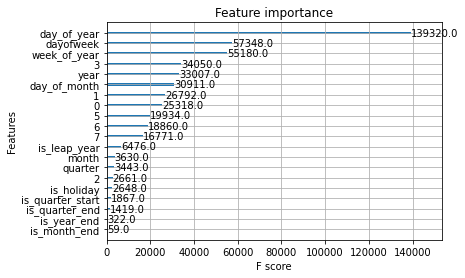

In [7]:
learning_rate = 0.001
xgb_model = XGBRegressor(n_estimators=10000,
                         learning_rate=learning_rate,
                         random_state=random_state)
xgb_model.fit(X_train, y_train,
              early_stopping_rounds=100,
              eval_set=[(X_val, y_val)],
              verbose=False)
_ = plot_importance(xgb_model)
best_iteration = xgb_model.best_iteration
print(f"Best Iteration: {best_iteration}")

In [8]:
predictions = xgb_model.predict(X_val)

## Step 3. Validate the Model

In [9]:
def smape(A, F):
    """
    Thanks https://stackoverflow.com/questions/51444630/how-to-use-smape-evaluation-metric-on-train-dataset and https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error
    """
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

print(f"SMAPE: {smape(y_val, predictions)}")

SMAPE: 8.360055703121306


## Step 4. Choose/Train the Complete Model

In [10]:
xgb_model = XGBRegressor(n_estimators=best_iteration,
                         learning_rate=learning_rate,
                         random_state=random_state)
X = pd.concat([X_train, X_val], axis=0)
y = pd.concat([y_train, y_val], axis=0)
xgb_model.fit(X, y, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.001, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=7704, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=3165,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

## Step 5. Predict Test Values

In [11]:
test_df = pd.read_csv("data/test.csv", index_col='row_id')
test_df['date'] = pd.to_datetime(test_df['date'], format='%Y-%m-%d')
display(test_df.head())
_ = create_time_features(test_df)
test_df, _ = one_hot_encode(test_df)
test_X = test_df[features]
display(test_X.head())

,date,country,store,product
row_id,,,,
26298,2019-01-01,Finland,KaggleMart,Kaggle Mug
26299,2019-01-01,Finland,KaggleMart,Kaggle Hat
26300,2019-01-01,Finland,KaggleMart,Kaggle Sticker
26301,2019-01-01,Finland,KaggleRama,Kaggle Mug
26302,2019-01-01,Finland,KaggleRama,Kaggle Hat


,0,1,2,3,4,5,6,7,dayofweek,quarter,...,day_of_month,week_of_year,is_holiday,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
row_id,,,,,,,,,,,,,,,,,,,,,
26298,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1,1,...,1,1,True,True,False,True,False,True,False,False
26299,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,1,...,1,1,True,True,False,True,False,True,False,False
26300,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1,...,1,1,True,True,False,True,False,True,False,False
26301,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1,1,...,1,1,True,True,False,True,False,True,False,False
26302,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1,1,...,1,1,True,True,False,True,False,True,False,False


In [12]:
predictions = np.round(xgb_model.predict(test_X))
test_df['num_sold'] = np.int64(predictions)
output = test_df['num_sold']
display(output)
output.to_csv('predictions/xgboost_predictions.csv')

row_id
26298     400
26299     603
26300     180
26301     694
26302    1037
         ... 
32863     820
32864     261
32865     952
32866    1409
32867     415
Name: num_sold, Length: 6570, dtype: int64